<a href="https://colab.research.google.com/github/MunYeong0723/gj-AI_WarmingUp/blob/MunYeong/%5Bmask_detection%5D_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2160, done.
remote: Counting objects: 100% (2160/2160), done.
remote: Compressing objects: 100% (1861/1861), done.
remote: Total 2160 (delta 510), reused 952 (delta 275), pack-reused 0
Receiving objects: 100% (2160/2160), 30.38 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (510/510), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [86]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.5)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

# Training Data

In [6]:
def annotate_box(x_center, y_center, width, height):
    y_min = y_center - height/2
    y_max = y_center + height/2

    x_min = x_center - width/2
    x_max = x_center + width/2

    return [y_min, x_min, y_max, x_max]

In [ ]:
import glob

train_img_path = glob.glob("/content/drive/My Drive/Colab Notebooks/yolo/images/train/*.jpg")
train_label_basePath = "/content/drive/My Drive/Colab Notebooks/yolo/labels/train/"

# Load images and visualize
train_images_np = []
gt_classes = []
gt_boxes = []

label_id_offset = 1
for i in range(len(train_img_path)):
    title = train_img_path[i].split("/")[-1]
    # train_img
    train_images_np.append(load_image_into_numpy_array(train_img_path[i]))
    # train_label
    path = train_label_basePath + title.replace(".jpg", ".txt")
    with open(path, 'r') as f :
        lines = f.readlines()
        tmp_class = []
        tmp_boxes = []
        for line in lines :
            tmp = line.split()
            tmp_class.append(int(tmp[0]) + label_id_offset)
            tmp_boxes.append(annotate_box(float(tmp[1]), float(tmp[2]), float(tmp[3]), float(tmp[4])))
        gt_classes.append(tmp_class)
        gt_boxes.append(np.array(tmp_boxes, dtype=np.float32))

    print(f"complete {i+1} / {len(train_img_path)}")

# print(gt_classes[:5])
# print(gt_boxes[:5])

# visualize train images
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np[:5]):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

# Prepare data for training

In [8]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
with_mask_class_id = 1
without_mask_class_id = 2
num_classes = 2

category_index = {
    with_mask_class_id : {'id' : with_mask_class_id, 'name' : 'with_mask'},
    without_mask_class_id : {'id' : without_mask_class_id, 'name' : 'without_mask'}
}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np, gt_class) in zip(train_images_np, gt_boxes, gt_classes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.array([gt_class], dtype=np.int32).reshape([gt_box_np.shape[0]]) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

# print(gt_classes_one_hot_tensors)
# zero_indexed_groundtruth_classes

Done prepping data.


# visualize train data as a sanity check

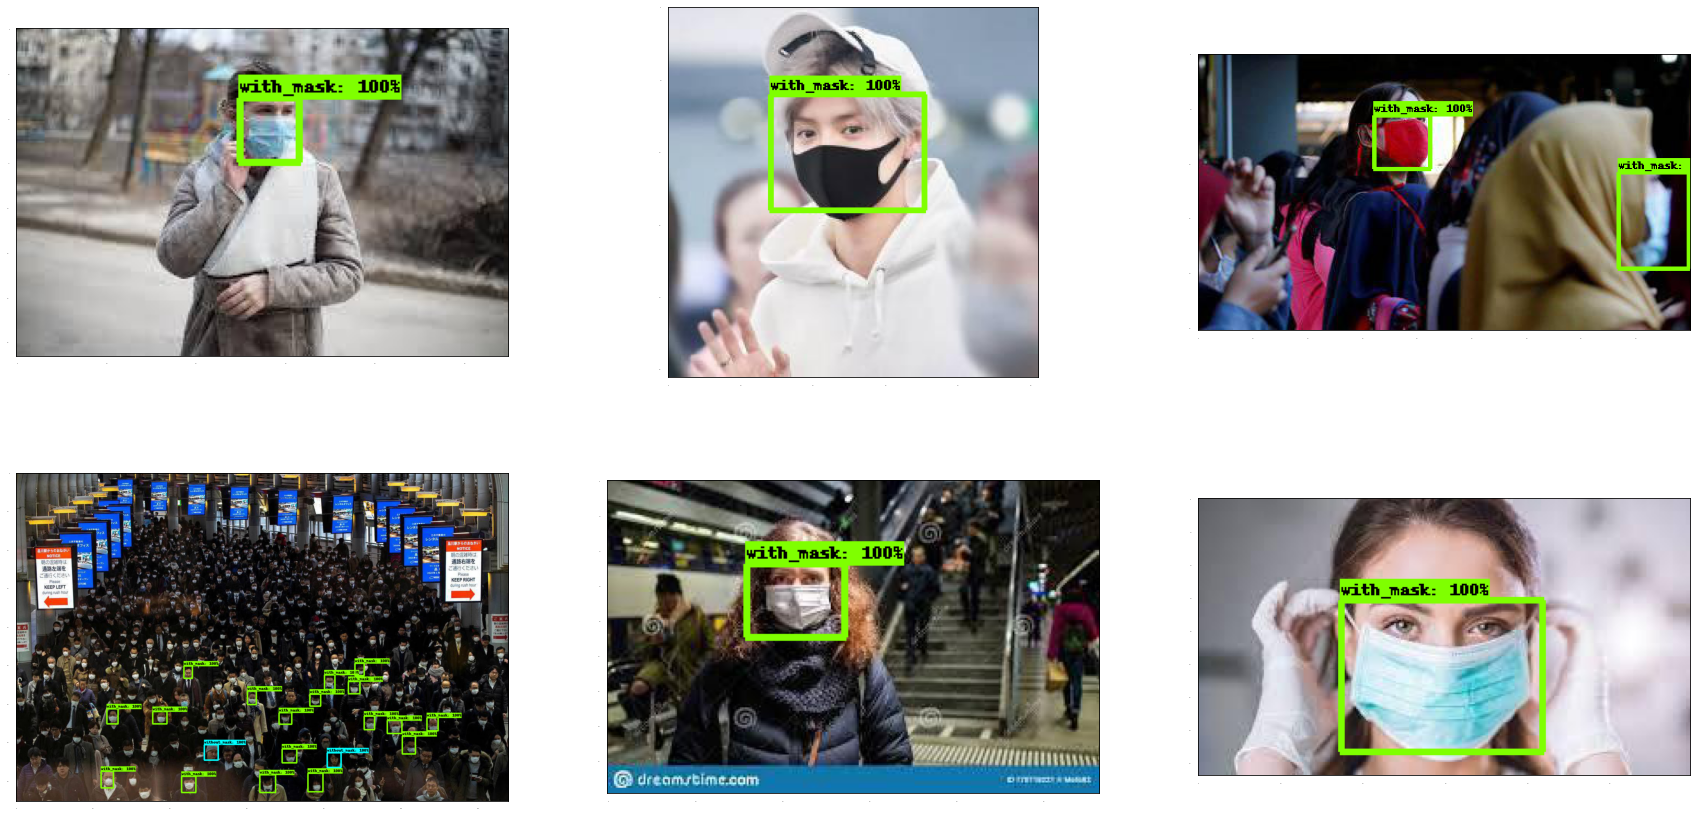

In [89]:
# mask_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
num = 1
for idx in range(50, 56):
  mask_scores = np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32)

  plt.subplot(2, 3, num)
  num += 1
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.array([gt_classes[idx]], dtype=np.int32).reshape([gt_boxes[idx].shape[0]]),
      mask_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In [34]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-09-08 08:11:31--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.167.128, 2a00:1450:400c:c0a::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.167.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.4’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   201MB/s    in 1.2s    

2020-09-08 08:11:33 (201 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.4’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [35]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 2
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop

In [36]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.

# batch_size = len(train_image_np) // 10
# learning_rate = 0.01
# num_batches = batch_size * 10

num_epochs = 10
learning_rate = 0.01
batch_size = len(train_image_tensors) // 30

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
#   @tf.function
  @tf.function(experimental_relax_shapes=True)
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat([detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for e in range(num_epochs):
    all_keys = list(range(len(train_image_tensors)))
    random.shuffle(all_keys)

    for idx in range(batch_size, len(train_image_tensors), batch_size):
        end = idx
        if end > len(train_image_tensors):
            end = len(train_image_tensors) - 1

        example_keys = all_keys[idx-batch_size : end]

        # Note that we do not do data augmentation in this demo.  If you want a
        # a fun exercise, we recommend experimenting with random horizontal flipping
        # and random cropping :)
        gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
        gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
        image_tensors = [train_image_tensors[key] for key in example_keys]

        # Training step (forward pass + backwards pass)
        total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

        # if idx % 10 == 0:
        #     print('batch ' + str(idx) + ' of ' + str(len(train_image_tensors))
        #     + ', loss=' +  str(total_loss.numpy()), flush=True)
        print('batch ' + str(idx) + ' of ' + str(len(train_image_tensors))
            + ', loss=' +  str(total_loss.numpy()), flush=True)

    # if e % 10 == 0:
    #     print('epoch ' + str(e) + ' of ' + str(num_epochs), flush=True)
    print('epoch ' + str(e) + ' of ' + str(num_epochs), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 25 of 768, loss=1.7103549
batch 50 of 768, loss=1.6512722
batch 75 of 768, loss=1.5208092
batch 100 of 768, loss=1.4422038


batch 125 of 768, loss=1.2826345


batch 150 of 768, loss=1.2007353


batch 175 of 768, loss=1.090763


batch 200 of 768, loss=1.0165311
batch 225 of 768, loss=1.0096011


batch 250 of 768, loss=0.94440776
batch 275 of 768, loss=0.7928782
batch 300 of 768, loss=0.8955371


batch 325 of 768, loss=0.91296613


batch 350 of 768, loss=0.96107435
batch 375 of 768, loss=0.8200345


batch 400 of 768, loss=0.8412376


batch 425 of 768, loss=0.76538503
batch 450 of 768, loss=0.62121093


batch 475 of 768, loss=0.88752615


batch 500 of 768, loss=0.8046174
batch 525 of 768, loss=0.81661004
batch 550 of 768, loss=0.7905543
batch 575 of 768, loss=0.9849781
batch 600 of 768, loss=0.6357994
batch 625 of 768, loss=0.8611125


batch 650 of 768, loss=0.87493414
batch 675 of 768, loss=0.8520731
batch 700 of 768, loss=0.77098787
batch 725 of 768, loss=0.6431633
batch 750 of 768, loss=0.8432653
epoch 0 of 10
batch 25 of 768, loss=0.77345175
batch 50 of 768, loss=0.64665294
batch 75 of 768, loss=0.6633736
batch 100 of 768, loss=0.8362181
batch 125 of 768, loss=0.64574397
batch 150 of 768, loss=0.72481453
batch 175 of 768, loss=0.7407607
batch 200 of 768, loss=0.6228167
batch 225 of 768, loss=0.71994644
batch 250 of 768, loss=0.54864025
batch 275 of 768, loss=0.58374304
batch 300 of 768, loss=0.68743944
batch 325 of 768, loss=0.6408913
batch 350 of 768, loss=0.62678766
batch 375 of 768, loss=0.7635222
batch 400 of 768, loss=0.7394887
batch 425 of 768, loss=0.7829112
batch 450 of 768, loss=0.6220691
batch 475 of 768, loss=0.66726637
batch 500 of 768, loss=0.6216905
batch 525 of 768, loss=0.8480763
batch 550 of 768, loss=0.51858103
batch 575 of 768, loss=0.7358551
batch 600 of 768, loss=0.64527357
batch 625 of 768, 

# Load test images and run inference with new model

In [ ]:
# valid_label_basePath = "/content/drive/My Drive/Colab Notebooks/yolo/labels/valid/"

# test_img_path = glob.glob("/content/drive/My Drive/Colab Notebooks/yolo/images/valid/*.jpg")
# test_label_basePath = "/content/drive/My Drive/Colab Notebooks/yolo/labels/valid/"
test_img_path = glob.glob("/content/drive/My Drive/Colab Notebooks/yolo/images/test/*.jpg")

test_img_np = []
# test_classes = []
# test_boxes = []
label_id_offset = 1

for i in range(len(test_img_path)):
    title = test_img_path[i].split("/")[-1]
    test_img_np.append(np.expand_dims(load_image_into_numpy_array(test_img_path[i]), axis=0))

    # path = test_label_basePath + title.replace(".jpg", ".txt")
    # with open(path, 'r') as f :
    #     # TODO : bounding box가 여러 개인 경우 처리하기
    #     lines = f.readlines()
    #     tmp_class = []
    #     tmp_boxes = []
    #     for line in lines :
    #         tmp = line.split()
    #         tmp_class.append(int(tmp[0]) + label_id_offset)
    #         tmp_boxes.append(annotate_box(float(tmp[1]), float(tmp[2]), float(tmp[3]), float(tmp[4])))
    #     test_classes.append(tmp_class)
    #     test_boxes.append(np.array(tmp_boxes, dtype=np.float32))

    print(f"complete {i+1} / {len(test_img_path)}")


# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

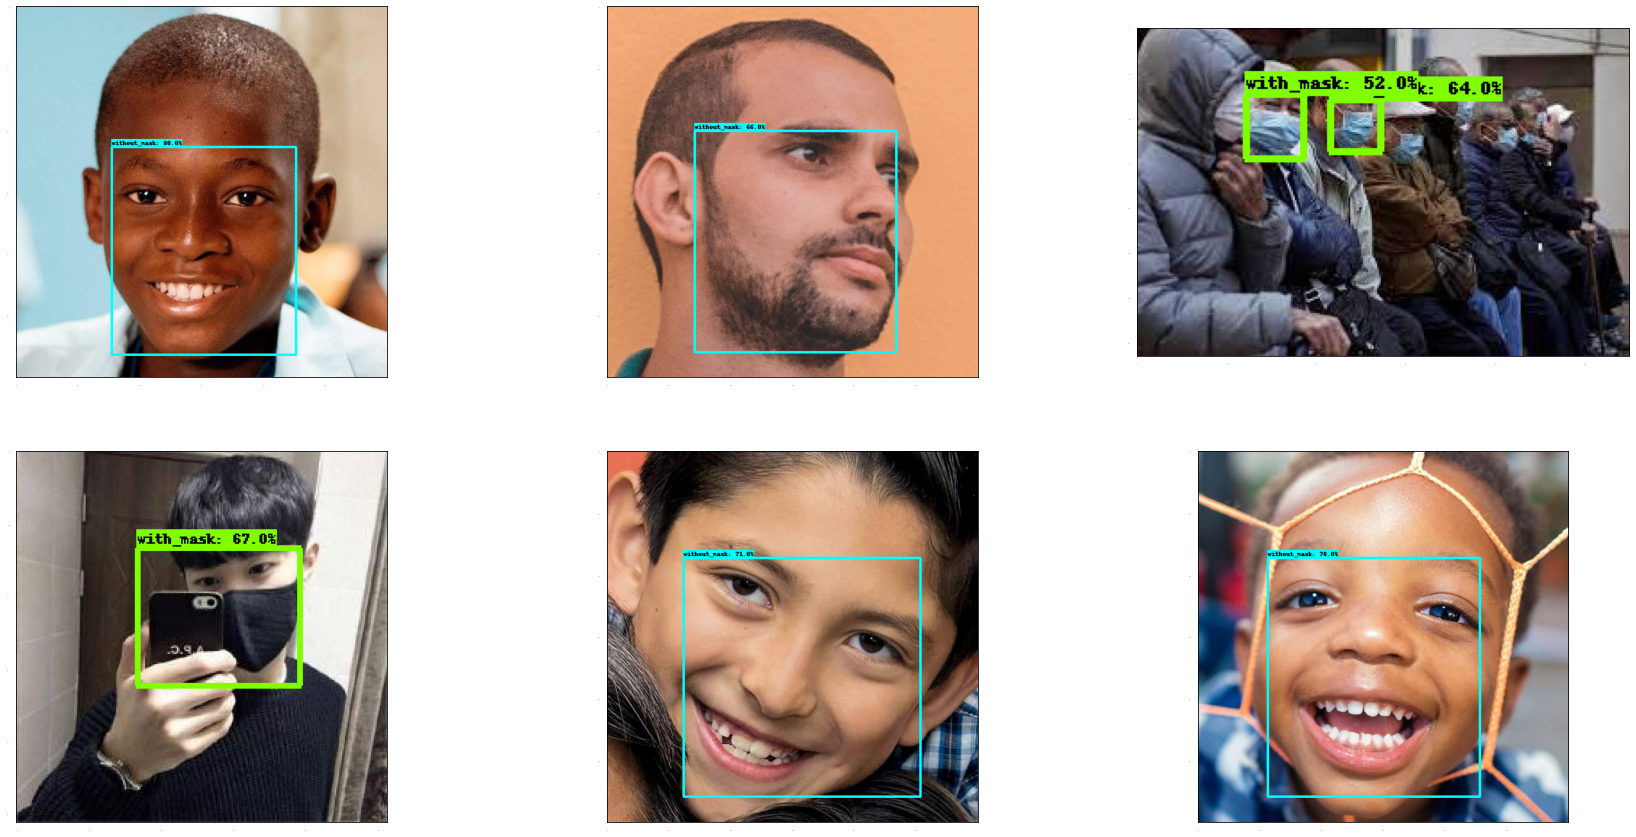

In [91]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.
label_id_offset = 1

plt.figure(figsize=(30, 15))
num = 0
for i in range(50,56):
  input_tensor = tf.convert_to_tensor(test_img_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plt.subplot(2, 3, num+1)
  num += 1
  plot_detections(
      test_img_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index)
plt.show()